<a href="https://colab.research.google.com/github/wujciak/thesis_colab/blob/main/transformers_thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Architektura Vision Transformer zaproponowana przez Google


In [1]:
import torch
import torch.nn as nn

In [2]:
class PatchEmbedding(nn.Module):
  """Split image into patches and then embed them.

  Parameters
  ----------
  img_size : int
    Size of the image (it is a square).
  patch_size : int
    Size of the patch (it is a square).
  in_chans : int
    Number of input channels.
  embed_dim : int
    The embedding dimension.

  Attributes
  ----------
  n_patches : int
    Number of patches inside of our image.
  proj : nn.Conv2d
    Convolutional layer that does both the splitting into patches
    and their embedding.
  """
  def __init__(self, img_size, patch_size, in_chans=3, embed_dim=768):
    super().__init__()
    self.img_size = img_size
    self.patch_size = patch_size
    self.n_patches = (img_size // patch_size) ** 2

    self.proj = nn.Conv2d(
        in_chans,
        embed_dim,
        kernel_size=patch_size,
        stride=patch_size,
    )

  def forward(self, x):
    """Run forward pass.

    Parameters
    ----------
    x : torch.Tensor
      Shape '(n_samples, in_chans, img_size, img_size)'.

    Returns
    -------
    torch.Tensor
      Shape '(n_samples, n_patches, embed_dim)'.
    """
    x = self.proj(
        x
    )  # (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
    x = x.flatten(2)  # (n_samples, embed_dim, n_patches)
    x = x.transpose(1, 2)  # (n_samples, n_patches, embed_dim)

    return x


class Attention(nn.Module):
  """Multi-head attention mechanism.

  Parameters
  ----------
  dim : int
    The input and out dimension of per token features.
  n_heads : int
    Number of attention heads.
  qkv_bias : bool
    If True then we include bias to the query, key and value projections.
  attn_p : float
    Dropout probability applied to the query, key and value tensors.
  proj_p : float
    Dropout probability applied to the output tensor.

  Attributes
  ----------
  scale : float
    Normalizing consant for the dot product.
  qkv : nn.Linear
    Linear projection for the query, key and value.
  proj : nn.Linear
    Linear mapping that takes in the concatenated output of all attention
    heads and maps it into a new space.
  attn_drop, proj_drop : nn.Dropout
    Dropout layers.
  """
  def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
    super().__init__()
    self.n_heads = n_heads
    self.dim = dim
    self.head_dim = dim // n_heads
    self.scale = self.head_dim ** -0.5

    self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
    self.attn_drop = nn.Dropout(attn_p)
    self.proj = nn.Linear(dim, dim)
    self.proj_drop = nn.Dropout(proj_p)

  def forward(self, x):
    """Run forward pass.

    Parameters
    ----------
    x : torch.Tensor
      Shape '(n_samples, n_patches + 1, dim)'.

    Returns
    -------
    torch.Tensor
      Shape '(n_samples, n_patches + 1, dim)'.
    """
    n_samples, n_tokens, dim = x.shape

    if dim != self.dim:
      raise ValueError

    qkv = self.qkv(x)  # (n_samples, n_patches + 1, 3 * dim)
    qkv = qkv.reshape(
        n_samples, n_tokens, 3, self.n_heads, self.head_dim
    )  # (n_samples, n_patches + 1, 3, n_heads, head_dim)
    qkv = qkv.permute(
        2, 0, 3, 1, 4
    )  # (3, n_samples, n_heads, n_patches + 1, head_dim)

    q, k, v = qkv[0], qkv[1], qkv[2]
    k_t = k.transpose(-2, -1)  # (n_samples, n_heads, head_dim, n_patches + 1)
    dp = (
        q @ k_t
    ) * self.scale  # (n_samples, n_heads, n_patches + 1, n_patches + 1)
    attn = dp.softmax(dim=-1)  # (n_samples, n_heads, n_patches + 1, n_patches + 1)
    attn = self.attn_drop(attn)

    weighted_avg = attn @ v  # (n_samples, n_heads, n_patches + 1, head_dim)
    weighted_avg = weighted_avg.transpose(
        1, 2
    )  # (n_samples, n_patches + 1, n_heads, head_dim)
    weighted_avg = weighted_avg.flatten(2)  # (n_samples, n_patches + 1, dim)

    x = self.proj(weighted_avg)  # (n_samples, n_patches + 1, dim)
    x = self.proj_drop(x)  # (n_samples, n_patches + 1, dim)

    return x


class MLP(nn.Module):
  """Multi-layer perceptron.

  Parameters
  ----------
  in_features : int
    Number of input features
  hidden_features : int
    Number of nodes in the hidden layer
  out_features : int
    Number of output features
  p : float
    Dropout probability

  Attributes
  ----------
  fc : nn.Linear
    The first linear layer
  act : nn.GELU
    GELU activation function
  fc2 : nn.Linear
    The second linear layer
  drop : nn.Dropout
    Dropout layer
  """
  def __init__(self, in_features, hidden_features, out_features, p=0.):
    super().__init__()
    self.fc1 = nn.Linear(in_features, hidden_features)
    self.act = nn.GELU()
    self.fc2 = nn.Linear(hidden_features, out_features)
    self.drop = nn.Dropout(p)

  def forward(self, x):
    """Run forward pass.

    Parameters
    ----------
    x : torch.Tensor
      Shape '(n_samples, in_features)'.

    Returns
    -------
    torch.Tensor
      Shape '(n_samples, out_features)'.
    """
    x = self.fc1(x)  # (n_samples, n_patches + 1, hidden_features)
    x = self.act(x)  # (n_samples, n_patches + 1, hidden_features)
    x = self.drop(x)  # (n_samples, n_patches + 1, hidden_features)
    x = self.fc2(x)  # (n_samples, n_patches + 1, hidden_features)
    x = self.drop(x)  # (n_samples, n_patches + 1, hidden_features)

    return x


class Block(nn.Module):
  """Transformer block.

  Parameters
  ----------
  dim : int
    Embedding dimension
  n_heads : int
    Number of attention heads
  mlp_ratio : float
    Determines the hidden dimension size of the `MLP` module with respect
    to `dim`
  qkv_bias : bool
    If True we include bias to the query, key and value projections
  p, attn_p : float
    Dropout probability

  Attributes
  ----------
  norm1, norm2 : nn.LayerNorm
    Layer normalization
  attn : Attention
    Attention module
  mlp : MLP
    MLP module.
  """
  def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
    super().__init__()
    self.norm1 = nn.LayerNorm(dim, eps=1e-6)
    self.attn = Attention(
        dim,
        n_heads=n_heads,
        qkv_bias=qkv_bias,
        attn_p=attn_p,
        proj_p=p
    )
    self.norm2 = nn.LayerNorm(dim, eps=1e-6)
    hidden_features = int(dim * mlp_ratio)
    self.mlp = MLP(
        in_features=dim,
        hidden_features=hidden_features,
        out_features=dim,
    )

  def forward(self, x):
    """Run forward pass.

    Parameters
    ----------
    x : torch.Tensor
      Shape '(n_samples, n_patches + 1, dim)'.

    Returns
    -------
    torch.Tensor
      Shape '(n_samples, n_patches + 1, dim)'.
    """
    x = x + self.attn(self.norm1(x))
    x = x + self.mlp(self.norm2(x))

    return x


class VisionTransformers(nn.Module):
  """Simplified implementation of the Vision Transformer

  Parameters
  ----------
  img_size : int
    Both height and width of the image (it is a square).
  patch_size : int
    Both height and width of the patch (it is a square).
  in_chans : int
    Number of input channels.
  n_classes : int
    Number of classes.
  embed_dim : int
    The embedding dimension
  depth : int
    Number of blocks.
  n_heads : int
    Number of attention heads.
  mlp_ratio : float
    Determines the hidden dimension size of the `MLP` module.
  qkv_bias : bool
    If True then we include bias to the query, key and value projections.
  p, attn_p : float
    Dropout probability.

  Attributes
  ----------
  patch_embed : PatchEmbedding
    Instance of 'PatchEmbed' layer.
  cls_token : nn.Parameter
    Learnable parameter that will represent the first token in the sequence.
    It has `embed_dim` elements.
  pos_embed : nn.Parameter
    Positional embedding of the cls token + all the patches.
    It has `(n_patches + 1) * embed_dim` elements.
  pos_drop : nn.Dropout
    Dropout layer.
  blocks : nn.ModuleList
    List of 'Block' modules.
  norm : nn.LayerNorm
    Layer normalization
  """
  def __init__(
      self,
      img_size=384,
      patch_size=16,
      in_chans=3,
      n_classes=2,
      embed_dim=768,
      depth=12,
      n_heads=12,
      mlp_ratio=4.,
      qkv_bias=True,
      p=0.,
      attn_p=0.,
  ):
    super().__init__()

    self.patch_embed = PatchEmbedding(
        img_size=img_size,
        patch_size=patch_size,
        in_chans=in_chans,
        embed_dim=embed_dim,
    )
    self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
    self.pos_embed = nn.Parameter(
        torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim)
    )
    self.pos_drop = nn.Dropout(p=p)

    self.blocks = nn.ModuleList(
        [
            Block(
                dim=embed_dim,
                n_heads=n_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                p=p,
                attn_p=attn_p,
            )
            for _ in range(depth)
        ]
    )

    self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
    self.head = nn.Linear(embed_dim, n_classes)

  def forward(self, x):
    """Run the forward

    Parameters
    ----------
    x : torch.Tensor
      Shape '(n_samples, in_chans, img_size, img_size)'.

    Returns
    -------
    logits : torch.Tensor
      Logits over all the classes - '(n_samples, n_classes)'.
    """
    n_samples = x.shape[0]
    x = self.patch_embed(x)

    cls_token = self.cls_token.expand(
        n_samples, -1, -1
    )  # (n_samples, 1, embed_dim)
    x = torch.cat((cls_token, x), dim=1)  # (n_samples, 1 + n_patches, embed_dim)
    x = x + self.pos_embed  # (n_samples, 1 + n_patches, embed_dim)
    x = self.pos_drop(x)

    for block in self.blocks:
      x = block(x)

    x = self.norm(x)
    cls_token_final = x[:, 0]  # just the CLS token
    x = self.head(cls_token_final)

    return x


# Implementacja modelu

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

In [4]:
# Stałe
DATASET_DIR = "/content/drive/MyDrive/Colab Notebooks/alg_and_batch1"
IMG_SIZE = 256
BATCH_SIZE = 32

# Normalizacja i zamiana na skale szarości
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Ładowanie danych
data = datasets.ImageFolder(DATASET_DIR, transform=transform)
class_names = data.classes

# Podział danych
train_idx, val_idx = train_test_split(
    list(range(len(data))), test_size=0.2, stratify=data.targets, random_state=42
)
train_data = torch.utils.data.Subset(data, train_idx)
val_data = torch.utils.data.Subset(data, val_idx)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
from collections import Counter

# Wyświetlenie liczby danych w zbiorach treningowych i walidacyjnych
print(f"Liczba próbek w zbiorze treningowym: {len(train_data)}")
print(f"Liczba próbek w zbiorze walidacyjnym: {len(val_data)}")

# Rozkład klas w zbiorze treningowym
train_labels = [data.targets[i] for i in train_idx]
train_class_counts = Counter(train_labels)
print("\nRozkład klas w zbiorze treningowym:")
for class_name, count in zip(class_names, train_class_counts.values()):
    print(f"{class_name}: {count}")

# Rozkład klas w zbiorze walidacyjnym
val_labels = [data.targets[i] for i in val_idx]
val_class_counts = Counter(val_labels)
print("\nRozkład klas w zbiorze walidacyjnym:")
for class_name, count in zip(class_names, val_class_counts.values()):
    print(f"{class_name}: {count}")


Liczba próbek w zbiorze treningowym: 4995
Liczba próbek w zbiorze walidacyjnym: 1249

Rozkład klas w zbiorze treningowym:
benign: 2299
malignant: 2696

Rozkład klas w zbiorze walidacyjnym:
benign: 575
malignant: 674


In [7]:
# Konfiguracja modelu pod zbiór danych
custom_config = {
    "img_size": IMG_SIZE,
    "patch_size": 16,
    "in_chans": 1,
    "n_classes": len(class_names),
    "embed_dim": 768,
    "depth": 12,
    "n_heads": 12,
    "qkv_bias": True,
    "mlp_ratio": 4.0,
    "p": 0.1,
    "attn_p": 0.1,
}

model = VisionTransformers(**custom_config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Wytyczne treningu
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=3e-6)  # dodanie weight decay
EPOCHS = 20

# Pętla treningowa
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        val_loss, val_acc = evaluate_model(model, val_loader, criterion)

        print(f"Epoch {epoch + 1}/{epochs}, "
              f"Train Loss: {running_loss / len(train_loader):.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

def evaluate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = correct / total
    return val_loss, val_acc

In [ ]:
# Start training
train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS)

# Save trained model
MODEL_PATH = "vision_transformer_usg.pth"
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Epoch 1/20, Train Loss: 0.7090, Val Loss: 0.7298, Val Acc: 0.4604
Epoch 2/20, Train Loss: 0.6968, Val Loss: 0.7561, Val Acc: 0.4604
Epoch 3/20, Train Loss: 0.6862, Val Loss: 0.6752, Val Acc: 0.5893
Epoch 4/20, Train Loss: 0.6691, Val Loss: 0.6834, Val Acc: 0.5805
Epoch 5/20, Train Loss: 0.6626, Val Loss: 0.7255, Val Acc: 0.5612
Epoch 6/20, Train Loss: 0.6531, Val Loss: 0.6787, Val Acc: 0.5813


Jedno ze szkoleń:

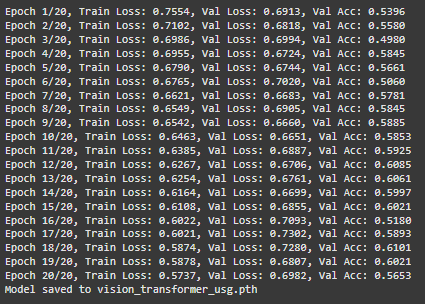